In [1]:
from keras.applications import VGG16
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

model = VGG16(weights='imagenet')

C:\Users\krishna\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


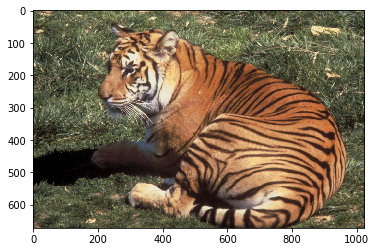

In [2]:
img_path = '../images/Tiger2.jpg'

img1 = image.load_img(img_path)
plt.imshow(img1);

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [3]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 2us/step
Predicted: [('n02129604', 'tiger', 0.8430918), ('n02123159', 'tiger_cat', 0.15662105), ('n02391049', 'zebra', 0.00011795545)]


In [4]:
np.argmax(preds[0])

292

In [6]:
tiger_output = model.output[:, 292]
last_conv_layer = model.get_layer('block5_conv3')

# Gradients of the Tiger class wrt to the block5_conv3 filer\n",
grads = K.gradients(tiger_output, last_conv_layer.output)[0]

# Each entry is the mean intensity of the gradient over a specific feature-map channel \n",
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Accesses the values we just defined given our sample image\n",
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# Values of pooled_grads_value, conv_layer_output_value given our input image\n",
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature-map array by the 'importance' \n",
# of this channel regarding the input image \n",
for i in range(512):
    #channel-wise mean of the resulting feature map is the Heatmap of the CAM\n",
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

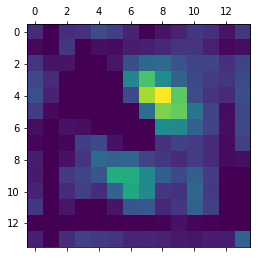

In [7]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

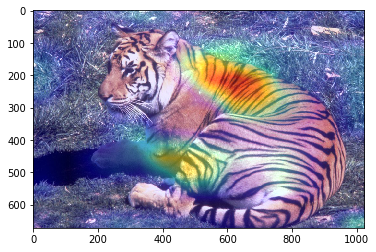

In [10]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

save_img_path = '../images/tiger_cam.jpg'
cv2.imwrite(save_img_path, superimposed_img)
img1 = image.load_img(save_img_path)
plt.imshow(img1)